## Common Spatial analysis tasks part 2

In this notebook we detail common operations on in-memory raster data.


#### Calculate statistics of a rasters within intersecting vectors

    Extract vector format data (e.g. projected polygons), overlay them onto an array (raster) extracted from either a tiff or netcdf, and extract statistics from the intersecting area.
    
    
#### Generate summary stats of vectors intersecting vectors

    Similar to previous task, except vector to vector.

#### Earth Engine: reduce regions on vectors
    Earth Engine version of generating summary stats over a region.

In [1]:
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterstats import zonal_stats
import geopandas as gpd
import numpy as np
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
%matplotlib inline

### Use National Shapefiles and Gridded Cloud data to see how cloudy it was at a particular time over Australia

First, read in some example shapefiles using Geopandas.

In [3]:
nations = gpd.read_file('./data/TM_WORLD_BORDERS_SIMPL-0/TM_WORLD_BORDERS_SIMPL-0.3.shp')

In [4]:
nations.head()

,AREA,FIPS,ISO2,ISO3,LAT,LON,NAME,POP2005,REGION,SUBREGION,UN,geometry
0,44,AC,AG,ATG,17.078,-61.783,Antigua and Barbuda,83039,19,29,28,(POLYGON ((-61.68666800000003 17.0244410000001...
1,238174,AG,DZ,DZA,28.163,2.632,Algeria,32854159,2,15,12,"POLYGON ((2.963610000000017 36.802216, 4.78583..."
2,8260,AJ,AZ,AZE,40.430,47.395,Azerbaijan,8352021,142,145,31,(POLYGON ((45.08332252502441 39.76804542541504...
3,2740,AL,AL,ALB,41.143,20.068,Albania,3153731,150,39,8,"POLYGON ((19.43621399999998 41.02106500000001,..."
4,2820,AM,AM,ARM,40.534,44.563,Armenia,3017661,142,145,51,"POLYGON ((45.15387153625488 41.1986026763916, ..."


Next, we iscolate Spain

In [47]:
aus = nations[nations.ISO3 == "AUS"]

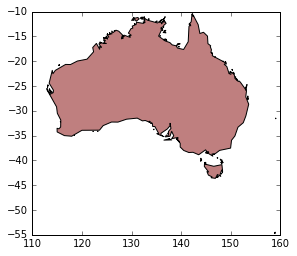

In [48]:
aus.plot()

We will also need to read the example MODIS cloud fraction data we used in the first notebook.

In [13]:
input_raster = "./data/modis_example.nc"
with rasterio.open(input_raster) as modisData:
    profile = modisData.profile
    cloudFraction = modisData.read()

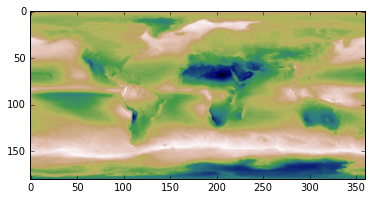

In [60]:
plt.imshow(cloudFraction[0],interpolation=None, cmap=cm.gist_earth)

* We will need to identify the coordinate system used in the raster data
* Extract geometry of concern (for script, can read country codes from a YAML file and iterate for each)
* Use a (reprojected) vector, with raster from the [rasterstats library](http://pythonhosted.org/rasterstats/manual.html) zonal_stats function

vector data should to be reprojected into the coordinate system of the raster data. In this case, the MODIS data are EPSG 4326. Using geopandas, the reprojection is as simple as:

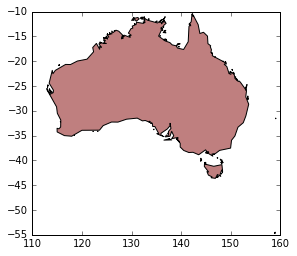

In [41]:
aus.to_crs(epsg="4326").plot()

In [50]:
output = zonal_stats(aus.to_crs(epsg="4326"), cloudFraction[0], band=1, all_touched=True,
                     raster_out=True, affine=profile['transform'], nodata=-999)

The output data structure contains the desired info, including a dictionary of statsistical summaries (to which new statistical reducers may be added), and also a clipped version of the input array:

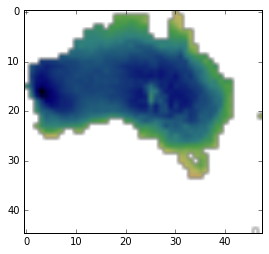

In [62]:
plt.imshow(output[0]['mini_raster_array'], interpolation=None, cmap=cm.gist_earth)

In [81]:
print(f"Pixels of data = {output[0]['count']}")
print(f"Maximum cloud fraction pixel = {output[0]['max']:5.2f}")
print(f"Min. cloud fraction pixel ={output[0]['min']:5.2f}")
print(f"Mean cloud fraction ={output[0]['min']:5.2f}")

Pixels of data = 812
Maximum cloud fraction pixel =  0.90
Min. cloud fraction pixel = 0.20
Mean cloud fraction = 0.20
